# Conditional-like execution and masking

This notebook shows how DALI arithmetic expressions can be used to achieve conditional-like application of augmentations and be used for some of the masking operations.

## Conditional results

We will create a Pipeline that will utilize DALI arithmetic expressions to apply augmentations conditionally its inputs. As DALI does not support executing parts of the graph in the Pipeline we will emulate the conditional operator in a similar fashion to [muxing](https://en.wikipedia.org/wiki/Multiplexer). Keep in mind that all possible inputs to our mux implementation will still be calculated by DALI.

### Imports

Let's start with the necessary imports.

In [1]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.types import Constant

### Operators used explicitly
We don't need to explicitly list arithmetic operators that we want to use in the Pipeline constructor. They work as regular Python operators in the `define_graph` step. 

As for the rest of Operators, our pipeline will use FileReader to provide us with input images. We also need an ImageDecoder to decode the loaded images.

We will use `CoinFlip` as a source for the random conditions. We will cast the result to bool, so it will play nicely with the type promotion rules.

As an example augmentation, we will apply the `BrightnessContrast` Operator. We choose quite extreme parameters, so it will clearly show in the output.

### The graph with custom augmentation

Let's proceed to `define_graph`. We start with typical load & decode approach.
Next we apply the augmentation. We keep handles to both tensors, unaugmented `imgs` and augmented `imgs_adjusted`.

We also need the `condition` - output of `CoinFlip` casted to bool.

## The mux operation

Now we want to calculate output `out` that is an equivalent to:

```
for idx in range(batch_size):
    if condition[idx]:
        out[idx] = imgs_adjusted[idx]
    else:
        out[idx] = imgs[idx]

```

We can transform the condition to an arithmetic expression:
```
out = condition * imgs_adjusted + (not condition) * imgs
```
when the condition is true we multiply the `imgs_adjusted` by `True` value (thus keeping it), while when it is `False` the multiplication yields `0`. Multiplying some numerical type by boolean keeps the numerical type. To implement the `else` branch, we need to negate the `condition` and do a similar multiplication. Then we just need to add them together.

Due to Python operator limitations, negating the boolean condition is implemented as a bitwise `xor` operation with constant equal to `1`.

We return the output of the mux operation, the original images, and `CoinFlip` values so we can easily visualize the results.

In [2]:
class MuxPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(MuxPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root="../images", file_list="../images/file_list.txt")
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.bool = ops.Cast(dtype=types.DALIDataType.BOOL)
        self.rng = ops.CoinFlip()
        self.bricon = ops.BrightnessContrast(brightness=3, contrast=1.5)
    
    def define_graph(self):
        input_buf, _ = self.input()
        imgs = self.decode(input_buf)
        imgs_adjusted = self.bricon(imgs)
        condition = self.bool(self.rng())
        
        neg_condition = Constant(1).bool() ^ condition
        out = condition * imgs_adjusted + neg_condition * imgs
        return out, imgs, condition

### Mux as a helper function

To clean things up we can even wrap the Mux in a helper function.

Note that the inputs to `mux` need to allow for the specified element-wise expression. In our case, the condition is a batch of Tensors representing scalars and the corresponding elements of the `true` and `false` cases have matching shapes.

In [3]:
def mux(condition, true_case, false_case):
    neg_condition = Constant(1).bool() ^ condition
    return condition * true_case + neg_condition * false_case

class MuxPipeline2(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(MuxPipeline2, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root="../images", file_list="../images/file_list.txt")
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.bool = ops.Cast(dtype=types.DALIDataType.BOOL)
        self.rng = ops.CoinFlip()
        self.bricon = ops.BrightnessContrast(brightness=3, contrast=1.5)
    
    def define_graph(self):
        input_buf, _ = self.input()
        imgs = self.decode(input_buf)
        imgs_adjusted = self.bricon(imgs)
        condition = self.bool(self.rng())
        
        out = mux(condition, imgs_adjusted, imgs)
        return out, imgs, condition

### Running the pipeline

Let's create an instance of the `Pipeline` and build it. We will use `batch_size = 5` so we can observe that some of the output images are augmented and some are not.

In [4]:
pipe = MuxPipeline2(batch_size = 5, num_threads=1, device_id=0)
pipe.build()

We will use a simple helper function to show the images. It takes the three outputs from out pipeline, puts the output of mux in left columnt, the original images on the right and asigns proper captions.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def display(augmented, reference, flip_value = None, cpu = True):
    data_idx = 0
    fig, axes = plt.subplots(len(augmented), 2, figsize=(15, 15))
    for i in range(len(augmented)):
        img = augmented.at(i) if cpu else augmented.as_cpu().at(i)
        ref = reference.at(i) if cpu else reference.as_cpu().at(i)
        if flip_value:
            val = flip_value.at(i)[0] if cpu else flip_value.as_cpu().at(i)[0]
        else:
            val = True
        axes[i, 0].imshow(np.squeeze(img))
        axes[i, 1].imshow(np.squeeze(ref))
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 0].set_title("Image was augmented" if val else "Image was not augmented")
        axes[i, 1].set_title("Reference decoded image")

Now, we will run and display the results. You can play this cell several times to see the result for different images.

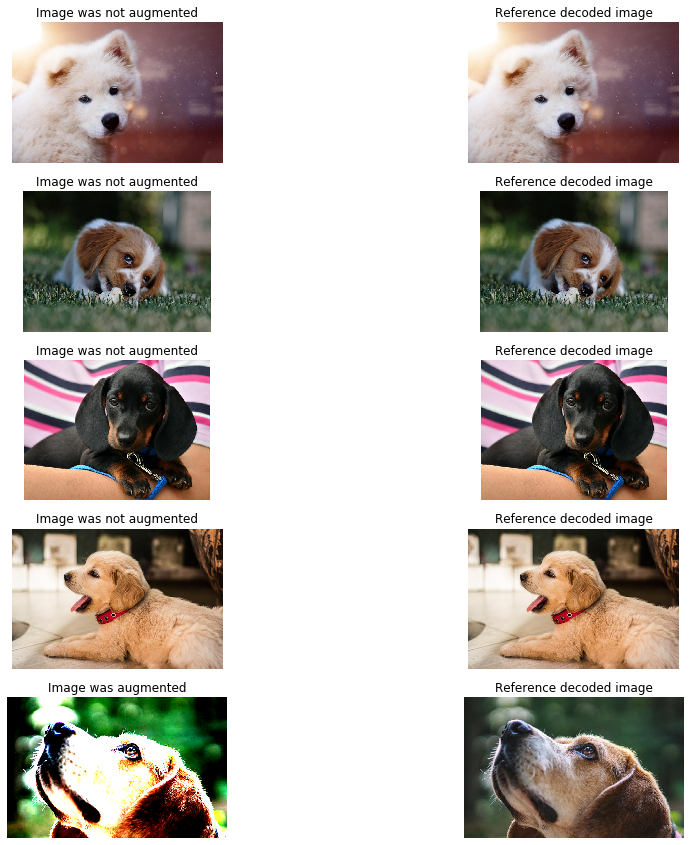

In [6]:
(output, reference, flip_val) = pipe.run()
display(output, reference, flip_val)

## Generating masks with comparisons and bitwise operations

Let's extend our pipeline to operate using some more complex logical conditions. We will use comparison operators to build masks representing regions where the image has low and high pixel intensities.

We will use bitwise **OR** operation to build a mask representing union of this regions. As the values in mask are boolean, the bitwise `|`, `&` `^` operations can be used in similar fashion as their logical counterparts.

As DALI arithmetic expressions are elementwise and specific channel values can vary a lot, we will calculate the masks on gray images, so we will get one value per pixel and duplicate the information to a 3-channel mask, so the shape of image and mask will match. For this we need two `ColorSpaceConversion` Operators, one handling RGB->Gray conversion and the second Gray->RGB.

We will aply brightening and darkening to specified regions using similar approach as before with muxing.

## Comparison operators

DALI allows to use all Python comparison operators directly. The Tensors that will be obtained from comparison contain boolean values.

Creating 1-channel masks for low and high intensities amouts to writing `imgs_gray < 30` and `imgs_gray > 230`.

Note that to convert the resulting boolean mask to 3-channel one, we need to cast it to `uint8` so the `ColorSpaceConversion` Operator will work. Unfortunately that might give some overhead and in practice may not be the most efficient way to calculate custom masks. If you need additional performance see the "Create a custom operator" to read about creating custom operators.

In [7]:
def not_(mask):
    return Constant(1).bool() ^ mask


class MasksPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(MasksPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root="../images", file_list="../images/file_list.txt")
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.bool = ops.Cast(dtype=types.DALIDataType.BOOL)
        self.uint8 = ops.Cast(dtype=types.DALIDataType.UINT8)
        self.rng = ops.CoinFlip()
        self.brighter = ops.BrightnessContrast(brightness=3)
        self.darker = ops.BrightnessContrast(brightness=0.75)
        self.gray = ops.ColorSpaceConversion(image_type=types.RGB, output_type=types.GRAY)
        self.rgb = ops.ColorSpaceConversion(image_type=types.GRAY, output_type=types.RGB)
    
    def expand_mask(self, mask):
        return self.bool(self.rgb(self.uint8(mask)))
    
    def define_graph(self):
        input_buf, _ = self.input()
        imgs = self.decode(input_buf)
        imgs_gray = self.gray(imgs)
        imgs_bright = self.brighter(imgs)
        imgs_dark = self.darker(imgs)
        
        mask_low = self.expand_mask(imgs_gray < 30)
        mask_high = self.expand_mask(imgs_gray > 230)
        mask_other = not_(mask_low | mask_high)
        
        out = mask_low * imgs_bright + mask_high * imgs_dark + mask_other * imgs
        return out, imgs, mask_other * Constant(255).uint8()

In [8]:
mask_pipe = MasksPipeline(batch_size = 5, num_threads=1, device_id=0)
mask_pipe.build()

We will adjust our display function so in addition to original and augmented images we can also see the masks that we obtained.

In [9]:
def display2(augmented, reference, mask, cpu = True):
    data_idx = 0
    fig, axes = plt.subplots(len(augmented), 3, figsize=(15, 15))
    for i in range(len(augmented)):
        img = augmented.at(i) if cpu else augmented.as_cpu().at(i)
        ref = reference.at(i) if cpu else reference.as_cpu().at(i)
        m = mask.at(i) if cpu else mask.as_cpu().at(i)
        axes[i, 0].imshow(np.squeeze(img))
        axes[i, 1].imshow(np.squeeze(ref))
        axes[i, 2].imshow(np.squeeze(m))
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 0].set_title("Augmented image")
        axes[i, 1].set_title("Reference decoded image")
        axes[i, 2].set_title("Calculated mask")

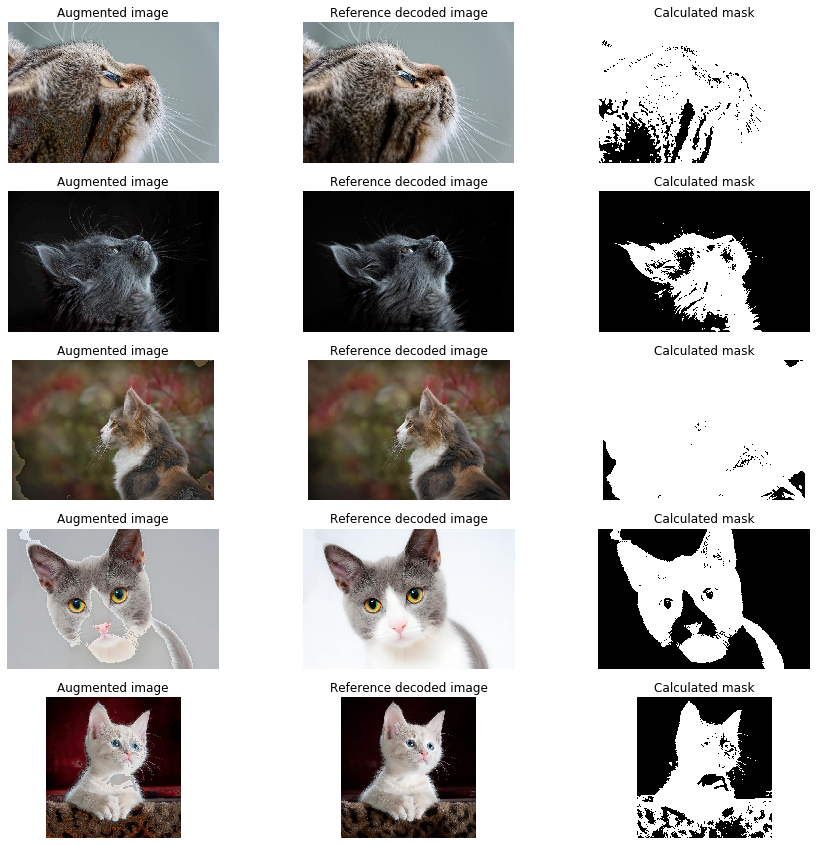

In [13]:
(output, reference, mask) = mask_pipe.run()
display2(output, reference, mask)